# 数据探索之参数估计


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import brfss  # 该模块用于处理BRFSS数据

%config InlineBackend.figure_format = 'retina'

df = brfss.ReadBrfss()  # 读取BRFSS数据

In [2]:
bmi = df.bmi.dropna()  # 取数据中的bmi列，并去除缺失值
len(bmi)  

405058

### 中心极限定理

In [3]:
def sampling_distribution(data, sample_size=20, bins=40):
    '''抽样分布模拟，输出均值、标准差以及直方图、ECDF图'''
    
    # 随机抽样
    sampling = [np.mean(np.random.choice(data, size=sample_size, replace=False)) for _ in range(1000)]  
    
    # 输出总体和抽样分布的均值、标准差
    mu = np.mean(data)
    se = np.std(data) / np.sqrt(sample_size)
    print('mean of sample means: %.2f' % np.mean(sampling))
    print('population means: %.2f' % mu)
    print('Standard deviation of sample means: %.2f' % np.std(sampling))
    print('Standard Error: %.2f' % se)

    # 绘制抽样分布的直方图、ECDF图
    fig = plt.figure(figsize=(16,5))
    p1 = fig.add_subplot(121)
    plt.hist(sampling, bins=bins, rwidth=0.9)
    plt.xlabel('sampling means')
    plt.ylabel('counts')
    p2 = fig.add_subplot(122)
    plot_ecdf(sampling, xlabel='sampling means', label='sampling ')
    sample = np.random.normal(mu, se, size=10000)
    plot_ecdf(sample, xlabel='sampling means', label='normal distribution')
    plt.show()
    
def ecdf(data):
    '''计算ECDF'''
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return (x,y)

def plot_ecdf(data, xlabel=None , ylabel='ECDF', label=None):
    '''绘制ECDF图'''
    x, y = ecdf(data)
    _ = plt.plot(x, y, marker='.', markersize=3, linestyle='none', label=label)
    _ = plt.legend(markerscale=4)
    _ = plt.xlabel(xlabel)
    _ = plt.ylabel(ylabel)
    plt.margins(0.02)

mean of sample means: 27.95
population means: 28.04
Standard deviation of sample means: 2.04
Standard Error: 2.10


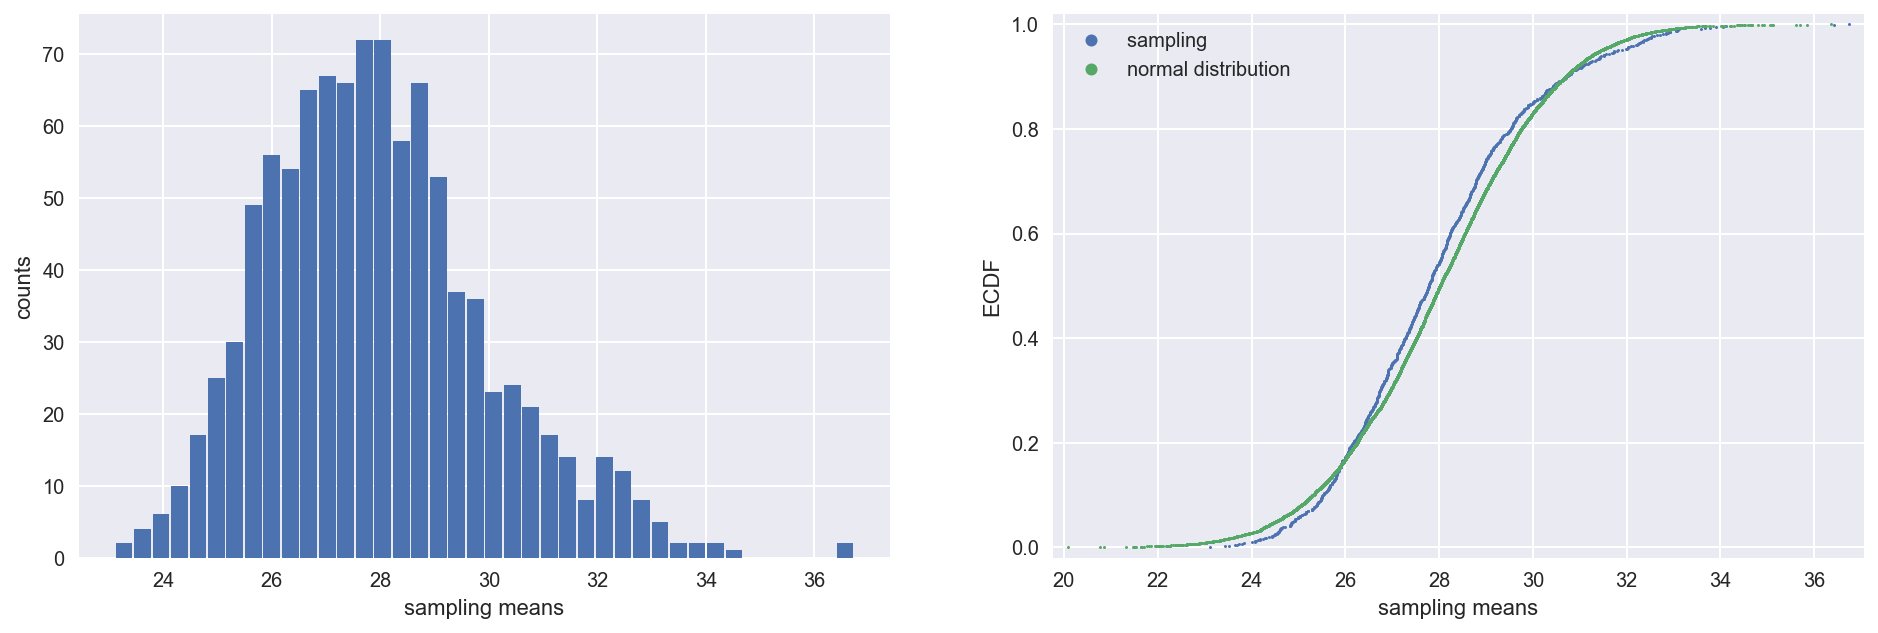

In [4]:
sampling_distribution(bmi, sample_size=10)

mean of sample means: 28.11
population means: 28.04
Standard deviation of sample means: 1.50
Standard Error: 1.49


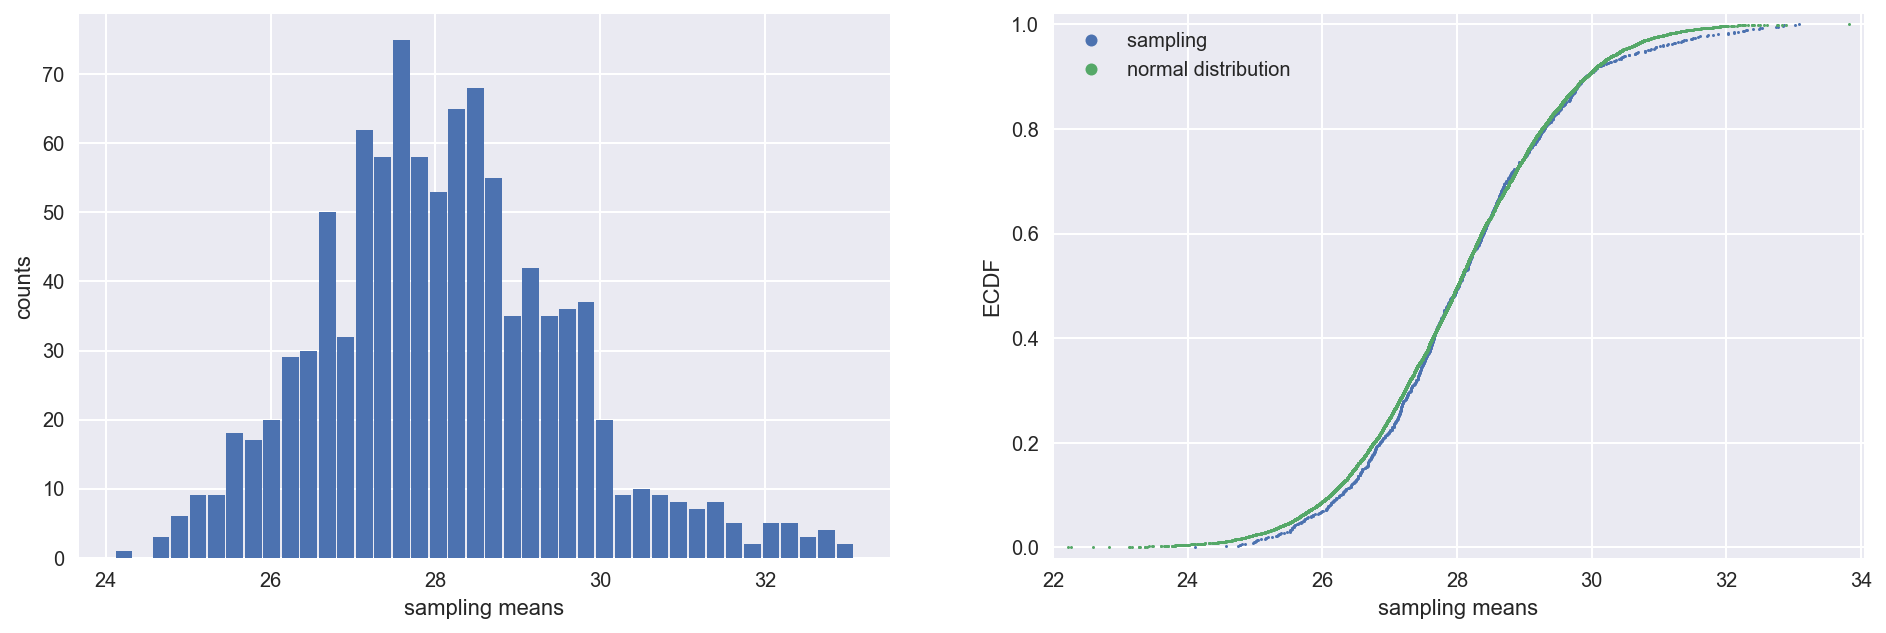

In [5]:
sampling_distribution(bmi, sample_size=20)

mean of sample means: 28.05
population means: 28.04
Standard deviation of sample means: 0.69
Standard Error: 0.67


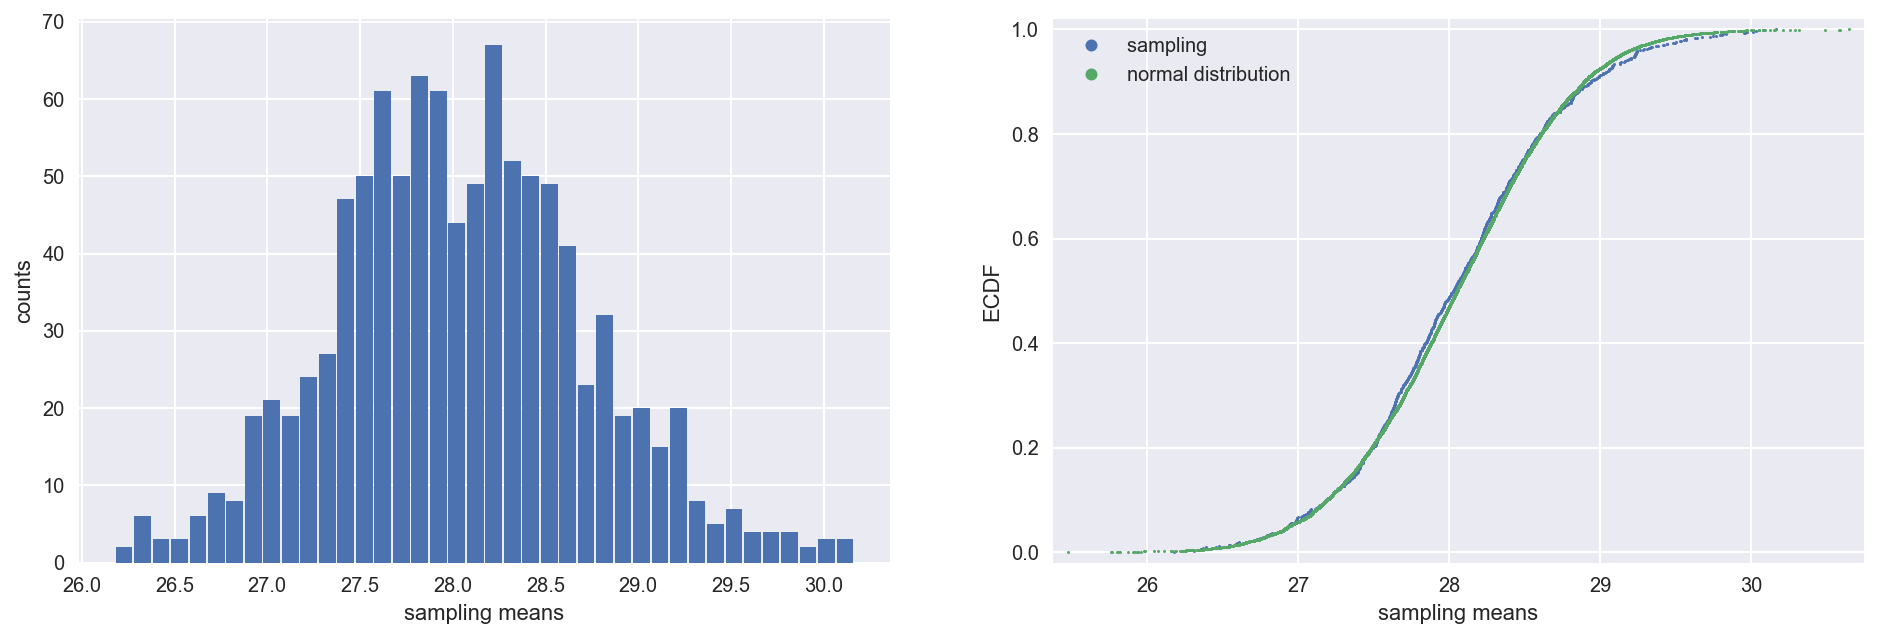

In [6]:
sampling_distribution(bmi, sample_size=100)

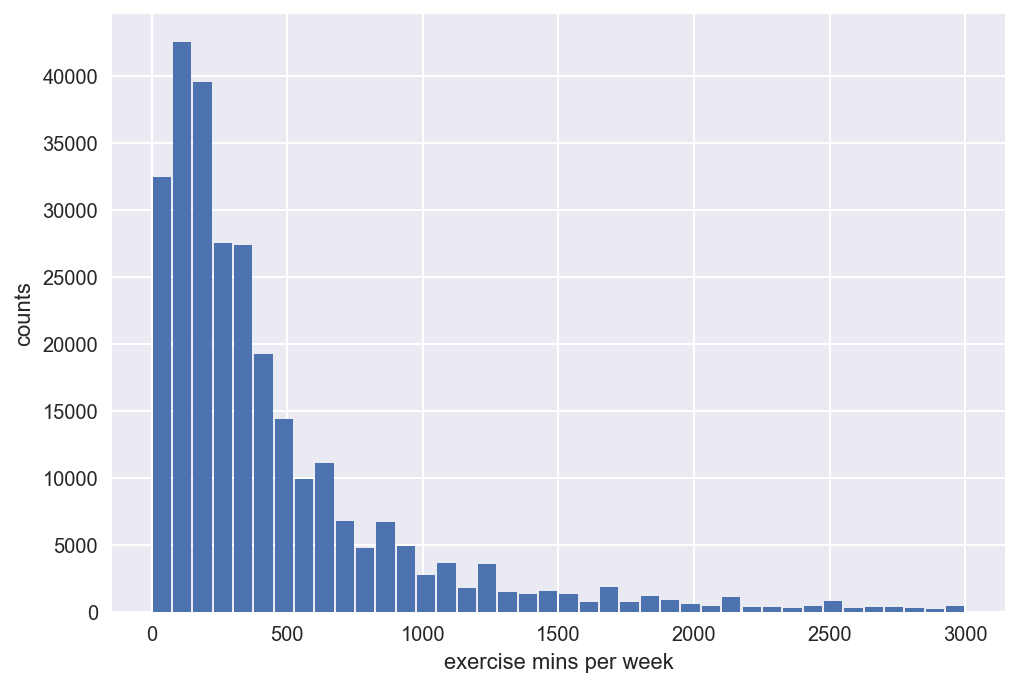

In [7]:
exemin = df[df.exemin != 0].exemin.dropna()   # 提取锻炼时间数据，丢弃0或者缺失值
plt.hist(exemin,bins=40, range=(0,3000), rwidth=0.9)  # 绘制直方图
plt.xlabel('exercise mins per week')
plt.ylabel('counts')
plt.show()

mean of sample means: 499.54
population means: 499.37
Standard deviation of sample means: 23.60
Standard Error: 23.75


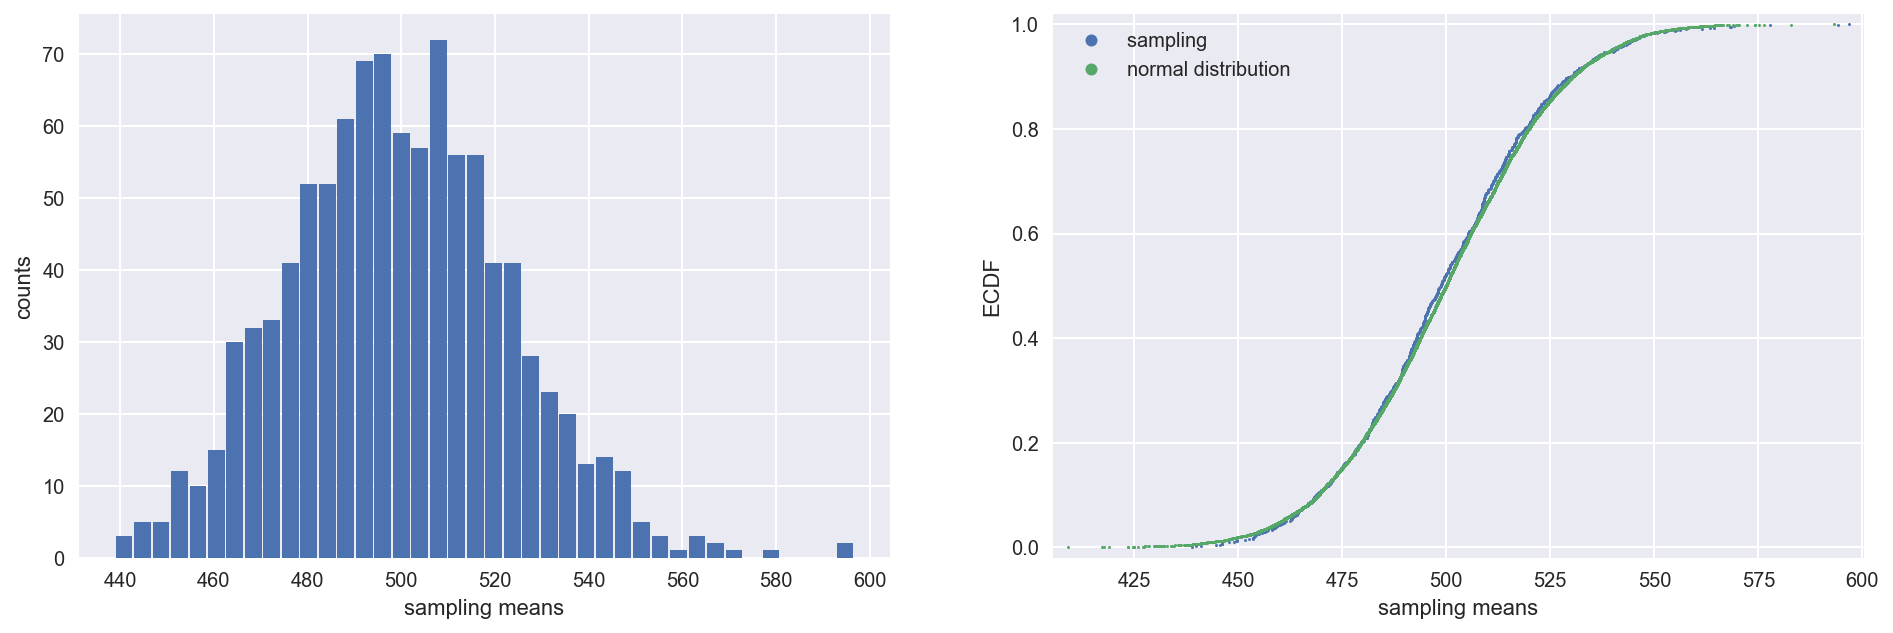

In [8]:
sampling_distribution(exemin, sample_size=1000)

### 正态分布的特性



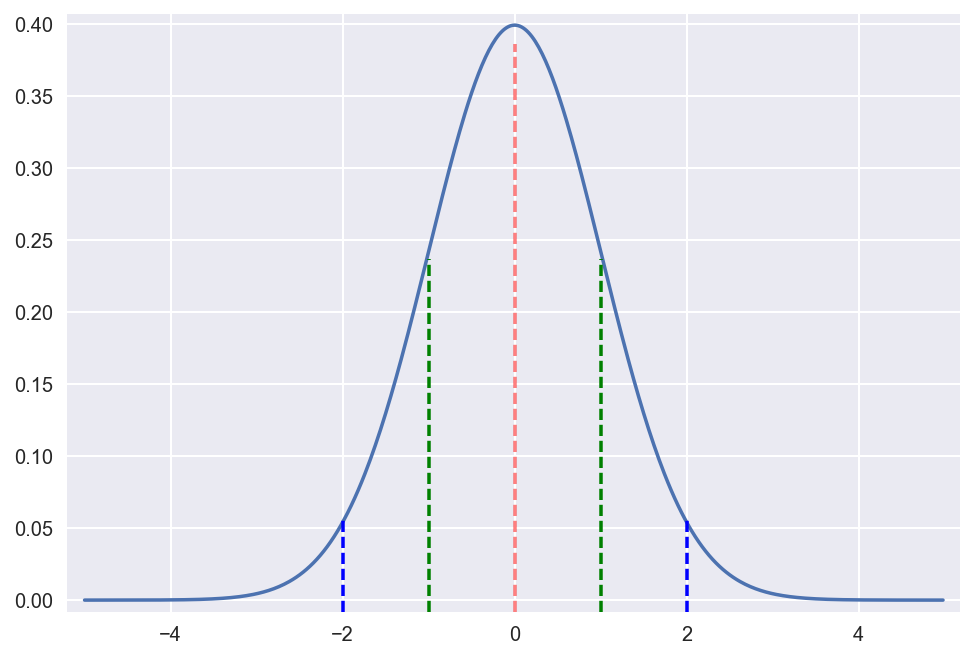

In [9]:
import scipy.stats
norm = scipy.stats.norm()  # 标准正态分布

x = np.arange(-5, 5, 0.02)
y = norm.pdf(x)  # 概率密度
plt.plot(x,y)
plt.axvline(x=0,ymax=0.95, linestyle='--', color='red', alpha=0.5)
plt.axvline(x=1,ymax=0.59, linestyle='--', color='green')
plt.axvline(x=-1,ymax=0.59, linestyle='--', color='green')
plt.axvline(x=2,ymax=0.16, linestyle='--', color='blue')
plt.axvline(x=-2,ymax=0.16, linestyle='--', color='blue')
plt.margins(0.02)
plt.show()


In [10]:
print('1 sigma : %.3f' % (norm.cdf(1) - norm.cdf(-1)))
print('2 sigma : %.3f' % (norm.cdf(2) - norm.cdf(-2)))
print('3 sigma : %.3f' % (norm.cdf(3) - norm.cdf(-3)))

1 sigma : 0.683
2 sigma : 0.954
3 sigma : 0.997


In [11]:
norm.interval(0.95)

(-1.959963984540054, 1.959963984540054)

In [12]:
norm.interval(0.99)

(-2.5758293035489004, 2.5758293035489004)

### 置信区间


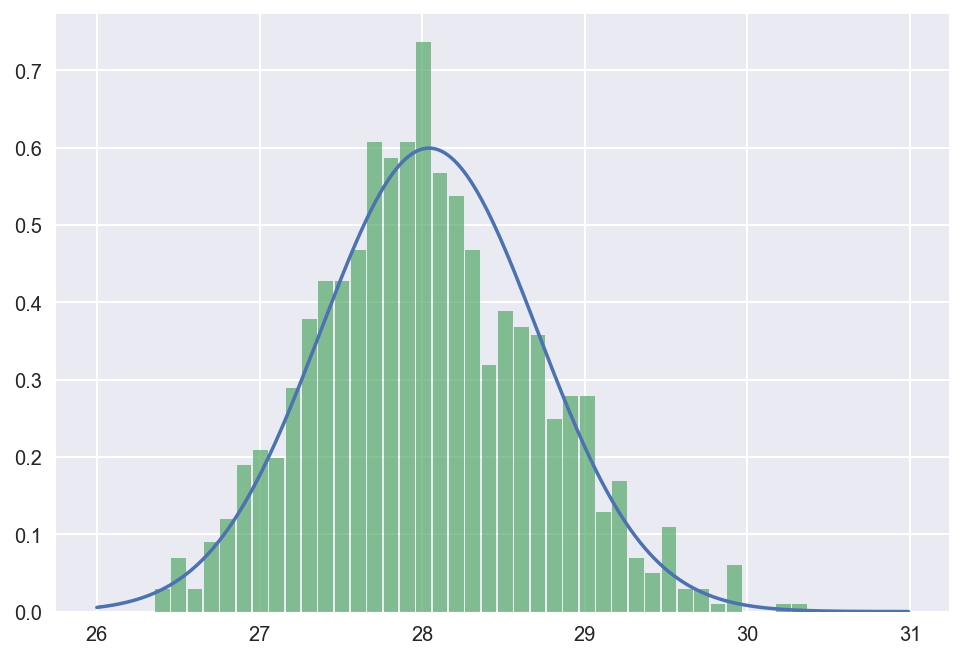

In [13]:
sample_size = 100    

# 计算总体的均值和标准差
mu = np.mean(bmi)
se = np.std(bmi) / np.sqrt(sample_size)
# 绘制正态分布的PDF
norm = scipy.stats.norm(mu, se)
x = np.arange(26, 31, 0.01)
y = norm.pdf(x)
plt.plot(x,y)

# 绘制抽样分布的直方图
sample_size = 100    
sampling = [np.mean(np.random.choice(bmi, size=sample_size, replace=False)) for _ in range(1000)]
plt.hist(sampling, bins=40, rwidth=0.9, normed=True, alpha=0.7)

plt.show()

In [14]:
norm.interval(0.95)

(26.738141245959351, 29.346706751112283)

In [15]:
norm.interval(0.99)

(26.328305902131977, 29.756542094939658)

### 区间估计的应用



In [16]:
df2 = df[['bmi', 'income']].dropna()  # 提取数据中bmi和收入水平income这两列，并忽略缺失值
bmi_rich = df2[df2.income == 8].bmi   # 收入水平为8级的，认为是富人
bmi_ord = df2[df2.income != 8].bmi    # 收入水平为1-7级的，认为是普通人群

In [17]:
def mean_ci(data):
    '''给定样本数据，计算均值95%的置信区间'''
    
    sample_size = len(data)
    std = np.std(data, ddof=1)  # 估算总体的标准差
    se = std / np.sqrt(sample_size)  # 计算标准误差   
    point_estimate = np.mean(data)  
    z_score = scipy.stats.norm.isf(0.025)  # 置信度95%
    confidence_interval = (point_estimate - z_score * se, point_estimate + z_score * se)

    return confidence_interval

In [18]:
mean_ci(bmi_rich)

(27.415906122294761, 27.485560606043915)

In [19]:
mean_ci(bmi_ord)

(28.509003170593907, 28.565637279855423)

In [20]:
mean_ci(bmi_rich[:500])

(27.849838839563304, 28.791561160436636)

In [21]:
mean_ci(bmi_ord[:500])

(28.200546441671069, 29.303493558328935)